In [20]:
import sys

sys.path.append('../')

import os
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

from kwave.ktransducer import *
from kwave.utils import *
from models.ADMM import ADMM_Batched
from models.APACT import APACT
from models.DAS import DAS
from models.Wiener import Wiener_Batched
from utils.data import *
from utils.reconstruction import *
from utils.simulations import PSF, get_water_SoS, wavefront_real
from utils.utils_torch import get_fourier_coord
from utils.visualization import *

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = '../data/'
results_path = '../results/'

### Load Sinogram

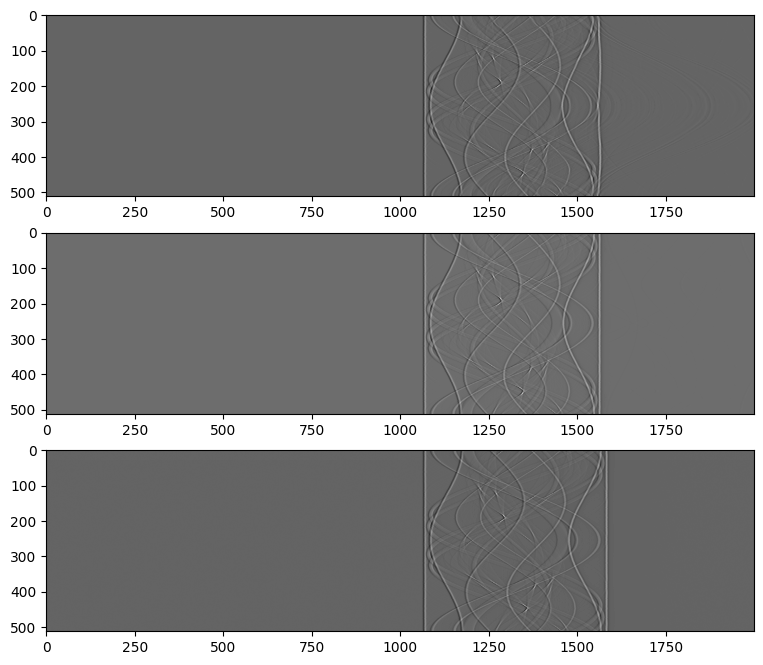

In [21]:
sinogram = load_mat(os.path.join(data_path, 'sinogram_simulation.mat'))
sinogram += np.random.normal(0, 1e-4, sinogram.shape)
sinogram_sb = load_mat(os.path.join(data_path, 'sinogram_simulation_sb.mat'))
sinogram_sb += np.random.normal(0, 1e-4, sinogram_sb.shape)
sinogram_uniform = load_mat(os.path.join(data_path, 'sinogram_simulation_uniform.mat'))
sinogram_uniform += np.random.normal(0, 1e-4, sinogram_uniform.shape)

plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.imshow(sinogram, cmap='gray')
plt.subplot(3,1,2)
plt.imshow(sinogram_sb, cmap='gray')
plt.subplot(3,1,3)
plt.imshow(sinogram_uniform, cmap='gray')
plt.show()

### Define Computational Grid

In [22]:
Nx, Ny = 560, 560
R_ring = 0.05   # Radius of the ring array [m].
dx, dy = 4e-5, 4e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
l = 3.2e-3 # Patch size [m].

### Define Parameters of Single-body SoS

In [23]:
R = 9.9e-3 # Radius to center [m].
T = 29.5 # Temperature of water [C].
v0 = get_water_SoS(T) # Background SoS [m/s].
v1 = 1564.4 # Avergae SoS in tissue [m/s].
print(v0, v1)

1508.0046878478038 1564.4


In [24]:
fwhm = 1.5e-3 # [m]
sigma = fwhm / 4e-5 / np.sqrt(2*np.log(2))
gaussian_window = torch.tensor(gaussian_kernel(sigma, 80), device=device)

### Uniform SoS

In [6]:
das = DAS(R_ring=0.05, N_transducer=512, T_sample=1/(40e6), x_vec=kgrid.x_vec[:], y_vec=kgrid.y_vec[:], mode='zero')
das.to(device)
das.eval()

with torch.no_grad():
    gt = das(torch.tensor(sinogram_uniform).to(device), 1508).detach().cpu().numpy()
    
save_mat(os.path.join(results_path, 'gt_simulation.mat'), gt.swapaxes(0,1), 'img')

### Conventional DAS

In [7]:
with torch.no_grad():
    rec_das = das(torch.tensor(sinogram).to(device), 1517.1).detach().cpu().numpy()
    rec_das_sb = das(torch.tensor(sinogram_sb).to(device), 1516.5).detach().cpu().numpy()
    
save_mat(os.path.join(results_path, 'das_simulation.mat'), rec_das.swapaxes(0,1), 'img')
save_mat(os.path.join(results_path, 'das_simulation_sb.mat'), rec_das_sb.swapaxes(0,1), 'img')

### APACT

In [29]:
delays_apact = np.arange(-8e-4, 8e-4, 1e-4)

apact = APACT(delays=delays_apact, dc_range=(0e-4, 4e-4), amp=3.2e-4, step=4e-5)
apact.to(device)
apact.eval()

APACT(
  (tf): TF_APACT()
  (loss): MSELoss()
)

In [30]:
recons, recons_sb = [], []
with torch.no_grad():
    for d_delay in delays_apact:
        recon = das(torch.tensor(sinogram).to(device), v0, d_delay)
        recons.append(recon)
        recon_sb = das(torch.tensor(sinogram_sb).to(device), v0, d_delay)
        recons_sb.append(recon_sb)
recons = torch.stack(recons, dim=0)
recons_sb = torch.stack(recons_sb, dim=0)

In [31]:
def deconv_full_apact(model, recons, gaussian_window):
    rec_apact = torch.zeros_like(recons[0], device=device)
    with torch.no_grad():
        for i in tqdm(range(25)):
            for j in tqdm(range(25)):
                obs = recons[:,20*i:20*i+80, 20*j:20*j+80] * gaussian_window
                obs = obs.unsqueeze(0).to(device)
                rec, _, _, _ = model(obs)
                rec_apact[20*i:20*i+80, 20*j:20*j+80] += rec.squeeze(0).squeeze(0)
            
    return rec_apact.detach().cpu().numpy()

rec_apact = deconv_full_apact(apact, recons, gaussian_window)
rec_apact_sb = deconv_full_apact(apact, recons_sb, gaussian_window)

100%|██████████| 25/25 [22:58<00:00, 55.14s/it]


In [32]:
save_mat(os.path.join(results_path, 'apact_simulation.mat'), rec_apact.swapaxes(0,1), 'img')
save_mat(os.path.join(results_path, 'apact_simulation_sb.mat'), rec_apact_sb.swapaxes(0,1), 'img')

### Deconvolution with Single Body PSFs

In [59]:
n_delays = 16
delays = get_delays(R, v0, v1, n_delays, 'uniform')

wiener = Wiener_Batched(lam=0.03)
admm = ADMM_Batched(n_iters=16, lam=0.1, rho=0.03)

In [26]:
recons, recons_sb = [], []
with torch.no_grad():
    for d_delay in delays:
        recon = das(torch.tensor(sinogram).to(device), v0, d_delay)
        recons.append(recon)
        recon_sb = das(torch.tensor(sinogram_sb).to(device), v0, d_delay)
        recons_sb.append(recon_sb)
recons = torch.stack(recons, dim=0)
recons_sb = torch.stack(recons_sb, dim=0)

In [39]:
l = 3.2e-3        
psfs = []
k2D, theta2D = get_fourier_coord(n_points=80, l=l, device='cpu')
with torch.no_grad():
    for i in range(25):
        for j in range(25):
            x, y = (j-12)*l / 4, (12-i)*l / 4
            r, phi = np.sqrt(x**2 + y**2), np.arctan2(x, y)
            w_real = wavefront_real(R, r, phi, v0, v1)
            psf = []
            for id, delay in enumerate(delays):
                psf.append(PSF(theta2D, k2D, w_real, delay))
            psfs.append(torch.stack(psf, dim=0))

In [60]:
def deconv_full_sb(model, recons, psfs, gaussian_window, delays, attention='uniform'):
    model.to(device)
    model.eval()
    
    rec_full = torch.zeros_like(recons[0], device=device)
    with torch.no_grad():
        for i in tqdm(range(25)):
            for j in range(25):
                obs = recons[:,20*i:20*i+80, 20*j:20*j+80]
                psf = psfs[i*25+j]
                mean = obs.abs().mean()
                _, C0 = get_r_C0(i, j, R, l, v0, v1)
                weights = torch.tensor(get_weights(C0, delays, attention), device=device)
                obs, psf = obs * torch.sqrt(weights), psf.to(device) * torch.sqrt(weights) # Apply attention weights to different channels.
                obs, psf = obs.unsqueeze(0), psf.unsqueeze(0)
                rec = model(obs/mean, psf) * mean
                rec_full[20*i:20*i+80, 20*j:20*j+80] += rec.squeeze(0).squeeze(0) * gaussian_window
    return rec_full.detach().cpu().numpy()

rec_wiener = deconv_full_sb(wiener, recons, psfs, gaussian_window, delays)
rec_wiener_sb = deconv_full_sb(wiener, recons_sb, psfs, gaussian_window, delays)

save_mat(os.path.join(results_path, 'sb_wiener_simulation.mat'), rec_wiener.swapaxes(0,1), 'img')
save_mat(os.path.join(results_path, 'sb_wiener_simulation_sb.mat'), rec_wiener_sb.swapaxes(0,1), 'img')
# save_mat(os.path.join(results_path, 'sb_admm_simulation.mat'), rec_sb_admm.swapaxes(0,1), 'img')

100%|██████████| 25/25 [00:00<00:00, 72.06it/s]


### Visualization

Load and normalize images.

In [61]:
IP_img = load_mat(os.path.join(data_path, 'IP.mat'))
gt = load_mat(os.path.join(results_path, 'gt_simulation.mat'))
rec_das = load_mat(os.path.join(results_path, 'das_simulation.mat'))
rec_apact = load_mat(os.path.join(results_path, 'apact_simulation.mat'))
rec_wiener = load_mat(os.path.join(results_path, 'sb_wiener_simulation.mat'))    
rec_wiener_sb = load_mat(os.path.join(results_path, 'sb_wiener_simulation_sb.mat'))

In [62]:
[IP_img, gt, rec_das, rec_apact, rec_wiener] = [normalize(img) for img in [IP_img, gt, rec_das, rec_apact, rec_wiener]]

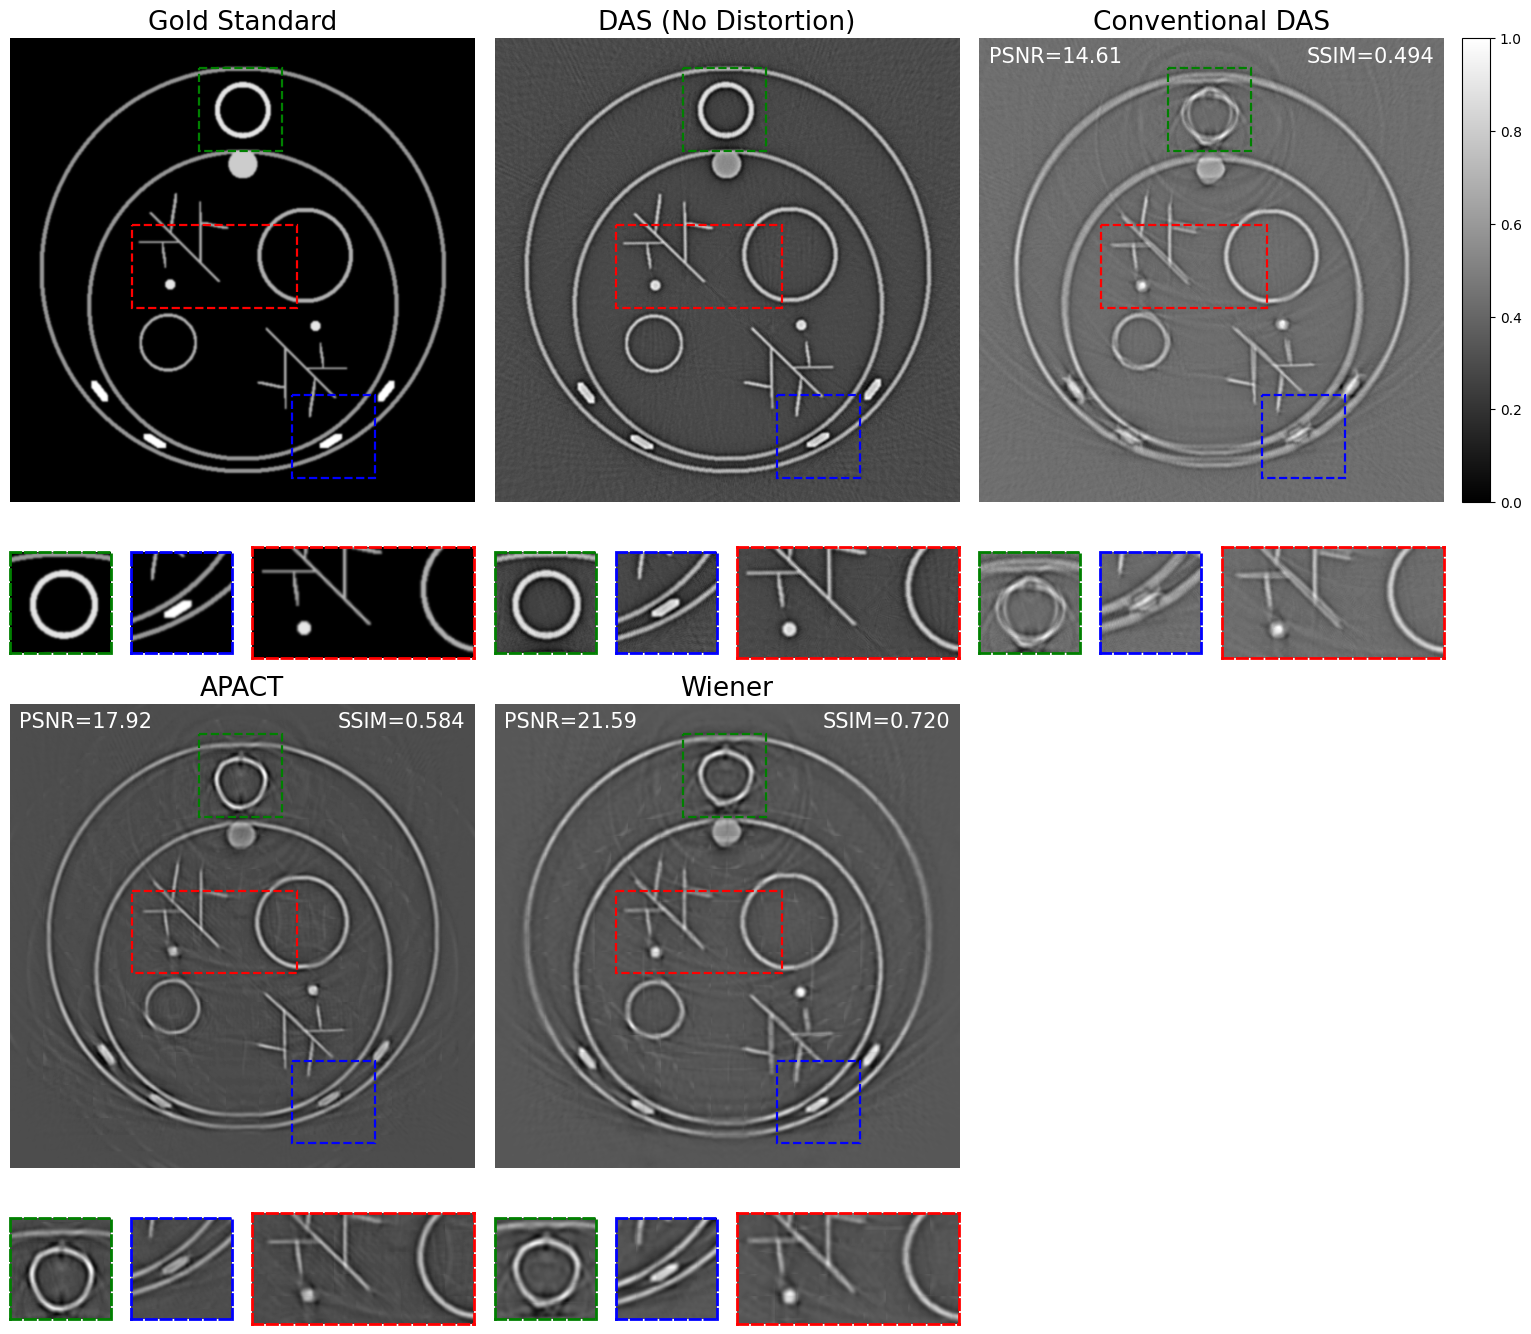

In [63]:
patches = [(36, 227, 100, 100, 'green'), (430, 340, 100, 100,'blue'), (225, 146, 100, 200, 'red')]

fig = plt.figure(figsize=(18.5, 17))
gs = gridspec.GridSpec(10, 12)
norm = matplotlib.colors.Normalize(vmax=1, vmin=-0)
for idx, (rec_full, method) in enumerate(zip([IP_img, gt, rec_das, rec_apact, rec_wiener], ['Gold Standard', 'DAS (No Distortion)', 'Conventional DAS', 'APACT', 'Wiener', 'ADMM'])):
    ax = plt.subplot(gs[(idx//3)*5:(idx//3)*5+4,(idx%3)*4:(idx%3+1)*4])
    plt.imshow(rec_full, cmap='gray', norm=norm)
    plt.title(method, fontsize=19)
    if idx > 1:
        plt.title('PSNR={:.2f}'.format(psnr(gt, rec_full, data_range=1)), loc='left', x=0.02, y=0.93, fontsize=15, color='white')
        plt.title('SSIM={:.3f}'.format(ssim(gt, rec_full, data_range=1)), loc='right', x=0.98, y=0.93, fontsize=15, color='white')
    plt.axis('off')
    if idx % 3 == 2:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.015, ax.get_position().height])
        cb = plt.colorbar(cax=cax)
    for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.6, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[(idx//3)*5+4:(idx//3)*5+5,(idx%3)*4+k:(idx%3)*4+k+1+(k==2)])
        plt.imshow(rec_full[x:x+h, y:y+w], cmap='gray', norm=norm)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(2)
            ax2.spines[loc].set_linestyle('--')